<a href="https://colab.research.google.com/github/jtao/dswebinar/blob/master/simpy/clinic_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import simpy
import os
import matplotlib.pyplot as plt
import random
import json
from networkx.readwrite import json_graph

Create Edges with corresponding weights:
 [('Entrance/Exit', 'Consultation1', {'weight': 1.0}), ('Consultation1', 'Entrance/Exit', {'weight': 1.0}), ('Consultation1', 'Consultation2', {'weight': 1.0}), ('Consultation2', 'Consultation1', {'weight': 1.0}), ('Consultation2', 'Consultation3', {'weight': 1.0}), ('Consultation3', 'Consultation2', {'weight': 1.0})]


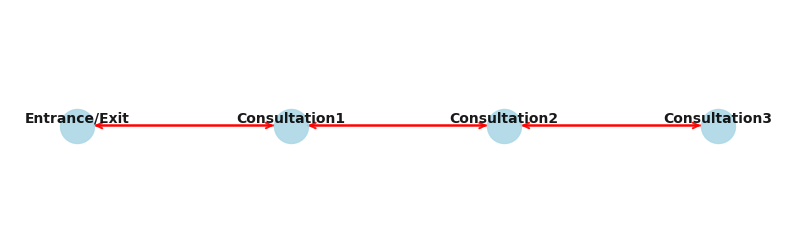

In [ ]:
output_path = '/Users/sreekiranv/Desktop/Healthcare_Systems/output/'
graph_name = 'graph_layout.json'

departments = {
    'Entrance/Exit': [(2, 2),0],
    'Consultation1': [(3, 2),1],
    'Consultation2': [(4, 2),2],
    'Consultation3': [(5, 2),3]}

edges = [(0,1),(1,0),(1,2),(2,1),(2,3),(3,2)]
    

def create_graph(departments, edges):
    # Create an empty graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(departments.keys())

    map_dict = {}
    for k,v in departments.items():
        map_dict[v[1]] = k

    updated_edges = []
    for e in edges:
        updated_edges.append((map_dict[e[0]],map_dict[e[1]]))

    weighted_edges = []
    for edge in updated_edges:
        dist = np.round(((departments[edge[0]][0][0]-departments[edge[1]][0][0])**2 +
                        (departments[edge[0]][0][1]-departments[edge[1]][0][1])**2)**0.5,0)
        weighted_edges.append((edge[0], edge[1], dist))

    edges = [(source, target, {'weight': weight})
    for source, target, weight in weighted_edges]

    print('Create Edges with corresponding weights:\n', edges)

    # Add the edges to the graph
    G = nx.DiGraph(edges)
    graph_data = nx.node_link_data(G)
    
    return G, graph_data


G, graph_data = create_graph(departments, edges)

# Set the positions of the nodes
pos = {node: position[0] for node, position in departments.items()}

# Draw the graph
plt.figure(figsize=(10,3))
nx.draw_networkx(
    G,
    pos=pos,
    node_size=600,
    with_labels=True,
    font_size=10,
    font_weight='bold',
    node_color='lightblue',
    edge_color='red',
    width=1.5,
    arrowstyle='->',
    arrowsize=10,
    alpha=0.9,
    verticalalignment='bottom'
)
plt.axis('off')


# Dump the graph to a JSON formatted string
filepath = os.path.join(output_path, graph_name)
with open(filepath, 'w') as f:
    json_data = json.dump(json_graph.node_link_data(G), f)

In [ ]:
class Patient:
    def __init__(self, env, id):
        self.env = env
        self.id = id
        self.done = False
        self.arrival_time = env.now
        self.consultation_start_time = None
        self.consultation_end_time = None
        self.exit_time = None
        self.consultation_room = None


class HospitalSimulation:
    def __init__(self, env, graph, num_patients, patient_arrival_rate):
        self.env = env
        self.graph = graph
        self.patients = []
        self.consultations = {}
        self.wait_times = []
        self.num_patients = num_patients
        self.patient_arrival_rate = patient_arrival_rate

        # Define the resource (consultation rooms)
        self.rooms = simpy.Resource(env, capacity=3)

        # Define the event triggers
        self.env.process(self.patient_arrivals())

    def patient_arrivals(self):
        for i in range(self.num_patients):
            # Add new patient to the queue
            patient = Patient(self.env, i+1)
            self.patients.append(patient)
            self.env.process(self.patient_consultation(patient))

            inter_arrival_time = random.randint(2,5) + np.round(random.expovariate(1.5), 0)
            yield self.env.timeout(inter_arrival_time)

    def patient_consultation(self, patient):
        # Record the arrival time
        patient.arrival_time = self.env.now

        # Request a consultation room
        with self.rooms.request() as request:
            yield request

            # Choose a random consultation room
            consultation_rooms = [n for n in self.graph.nodes if "Consultation" in n]
            room = random.choice(consultation_rooms)

            # Record the consultation start time
            patient.consultation_start_time = np.round(self.env.now,0)

            # Travel to the consultation room
            path = nx.shortest_path(self.graph, "Entrance/Exit", room)
            travel_time = len(path) - 1 # each edge has weight 1
            patient.travel_time = travel_time
            yield self.env.timeout(travel_time)

            # Start the consultation
            if room not in self.consultations:
                self.consultations[room] = []
            self.consultations[room].append(patient)
            patient.consultation_room = room
            consultation_time = random.uniform(10, 20) # uniform consultation time between 10 and 20 minutes
            yield self.env.timeout(consultation_time)

            # Record the total wait time for the patient
            patient.wait_time = patient.consultation_start_time - patient.arrival_time
            self.wait_times.append(patient.wait_time)

            # Travel back to the entrance/exit
            path.reverse()
            yield self.env.timeout(travel_time)

            # Record the consultation end time
            patient.consultation_end_time = self.env.now

            # Record the exit time
            patient.exit_time = self.env.now

            patient.done = True

    def get_patient_timestamps(self):
        timestamps = {}
        for patient in self.patients:
            timestamps[patient.id] = {
                'arrival_time': patient.arrival_time,
                'wait_start_time': patient.arrival_time,
                'wait_end_time': patient.consultation_start_time,
                'consultation_start_time': patient.consultation_start_time,
                'travel_time': patient.travel_time,
                'consultation_room': patient.consultation_room,
                'consultation_end_time': np.round(patient.consultation_end_time, 0),
                'exit_time': np.round(patient.exit_time + patient.travel_time, 0)}
        return timestamps

In [ ]:
output_path = '/Users/sreekiranv/Desktop/Healthcare_Systems/output/'
graph_name = 'graph_layout.json'

def run_simulation(num_patients, patient_arrival_rate):
    # Load the graph
    with open(os.path.join(output_path, graph_name), 'r') as f:
        data = json.load(f)
    graph = json_graph.node_link_graph(data)

    # Create the simulation environment
    env = simpy.Environment()

    # Run the simulation
    sim = HospitalSimulation(env, graph, num_patients, patient_arrival_rate)
    env.run()

    # Get the patient timestamps as a consolidated dataframe
    patient_timestamps = pd.DataFrame.from_dict({k: v for k, v in sim.get_patient_timestamps().items()}, orient='index')
    patient_timestamps['Patient_ID'] = range(1, patient_timestamps.shape[0]+1)

    # Print the average wait time
    print("Average wait time: ", np.mean(sim.wait_times))

    return patient_timestamps


In [ ]:
par = random.randint(2,5) + np.round(random.expovariate(1.5), 0)
data = run_simulation(100, par)

Average wait time:  94.4


In [ ]:
par = random.randint(2,5) + np.round(random.expovariate(1.5), 0)

In [ ]:
data.head(10)

,arrival_time,wait_start_time,wait_end_time,consultation_start_time,travel_time,consultation_room,consultation_end_time,exit_time,Patient_ID
1,0.0,0.0,0.0,0.0,3,Consultation3,22.0,25.0,1
2,5.0,5.0,5.0,5.0,1,Consultation1,26.0,27.0,2
3,10.0,10.0,10.0,10.0,2,Consultation2,27.0,29.0,3
4,19.0,19.0,22.0,22.0,3,Consultation3,47.0,50.0,4
5,23.0,23.0,26.0,26.0,2,Consultation2,43.0,45.0,5
6,25.0,25.0,27.0,27.0,2,Consultation2,43.0,45.0,6
7,33.0,33.0,43.0,43.0,1,Consultation1,57.0,58.0,7
8,36.0,36.0,43.0,43.0,2,Consultation2,58.0,60.0,8
9,41.0,41.0,47.0,47.0,1,Consultation1,65.0,66.0,9
10,47.0,47.0,57.0,57.0,1,Consultation1,74.0,75.0,10


In [ ]:
import pandas as pd

# Create an empty list to store the rows of the new dataframe
rows = []

# Iterate over each row of the original dataframe
for index, row in data.iterrows():
    patient_id = row["Patient_ID"]
    arrival_time = row["arrival_time"]
    wait_start_time = row["wait_start_time"]
    wait_end_time = row["wait_end_time"]
    consultation_start_time = row["consultation_start_time"]
    travel_time = row["travel_time"]
    consultation_end_time = row["consultation_end_time"]
    exit_time = row["exit_time"]
    consultation_room = row['consultation_room']

    # Iterate over the timestamps from arrival time to exit time
    for timestamp in range(int(arrival_time), int(exit_time)+1):
        position = None
        if timestamp == int(arrival_time):
            position = "Arrived"
        elif timestamp >= int(wait_start_time) and timestamp <= int(wait_end_time):
            position = "Waiting"
        elif timestamp > int(wait_end_time) and timestamp <= int(consultation_start_time)+travel_time:
            position = "Travelling"
        elif timestamp > int(consultation_start_time) and timestamp < int(consultation_end_time):
            position = "Consultation"
        elif timestamp >= int(consultation_end_time) and timestamp < int(consultation_end_time)+travel_time:
            position = "Travelling"
        elif timestamp == int(exit_time):
            position = "Exited"

        # Create a new row with the patient's position at this timestamp
        new_row = {
            "timestamp": timestamp,
            "patient_id": patient_id,
            "position": position,
            "consultation_room": consultation_room
        }
        rows.append(new_row)
    

# Create a new dataframe from the rows list
new_df = pd.DataFrame(rows)
new_df['patient_id'] = new_df['patient_id'].astype(int)

In [ ]:
def create_patient_journey(patient_df):
    patient_journey = {}
    patient_positions = patient_df['position'].unique()
    for position in patient_positions:
        if position == 'Arrived':
            patient_journey[position] = patient_df.loc[patient_df['position'] == position, 'timestamp'].iloc[0]
        elif position == 'Exited':
            patient_journey[position] = patient_df.loc[patient_df['position'] == position, 'timestamp'].iloc[0]
        else:
            timestamps = tuple(patient_df.loc[patient_df['position'] == position, 'timestamp'])
            patient_journey[position] = timestamps
    patient_journey['consultation_room'] = patient_df['consultation_room'].unique()[0]
    return patient_journey

# group by patient_id and create patient journey
df_grouped = new_df.groupby('patient_id').apply(create_patient_journey)

# reset index and rename columns
df_grouped = df_grouped.reset_index()
df_grouped = df_grouped.rename(columns={'level_1': 'patient_journey', 0: 'patient_journey_dict'})

# keep only patient_id and patient_journey columns
output = df_grouped[['patient_id', 'patient_journey_dict']]

In [ ]:
from itertools import groupby
from operator import itemgetter

def process_dictionary(original_dict):
    # Group consecutive numbers in Travelling key into tuples
    travelling_list = []
    for k, g in groupby(enumerate(original_dict['Travelling']), lambda i_x: i_x[0]-i_x[1]):
        group = list(map(itemgetter(1), g))
        travelling_list.append((group[0], group[-1]))

    # Create the new dictionary
    new_dict = {'Arrived': original_dict['Arrived'],
                'Travelling': tuple(travelling_list),
                'Consultation': (min(original_dict['Consultation']), max(original_dict['Consultation'])),
                'Exited': original_dict['Exited'],
                'consultation_room': original_dict['consultation_room']}

    return new_dict

In [ ]:
output['patient_journey_dict'] = output['patient_journey_dict'].apply(lambda x: process_dictionary(x))


# Save data in JSON format
json_data = output.to_json(orient='records')

# Save JSON data to a file
with open(output_path+'simulated_data_v1.json', 'w') as f:
    f.write(json_data)

In [ ]:
output.head(20)

,patient_id,patient_journey_dict
0,1,"{'Arrived': 0, 'Travelling': ((1, 3), (22, 24)..."
1,2,"{'Arrived': 5, 'Travelling': ((6, 6), (26, 26)..."
2,3,"{'Arrived': 10, 'Travelling': ((11, 12), (27, ..."
3,4,"{'Arrived': 19, 'Travelling': ((23, 25), (47, ..."
4,5,"{'Arrived': 23, 'Travelling': ((27, 28), (43, ..."
5,6,"{'Arrived': 25, 'Travelling': ((28, 29), (43, ..."
6,7,"{'Arrived': 33, 'Travelling': ((44, 44), (57, ..."
7,8,"{'Arrived': 36, 'Travelling': ((44, 45), (58, ..."
8,9,"{'Arrived': 41, 'Travelling': ((48, 48), (65, ..."
9,10,"{'Arrived': 47, 'Travelling': ((58, 58), (74, ..."
